In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hydrotools.nwis_client.iv import IVDataService
%matplotlib widget

In [4]:
client = IVDataService()
streamflow = client.get(
    sites="02146470",
    startDT="2019-10-01",
    endDT="2020-09-30"
    )
rainfall = client.get(
    sites="351104080521845",
    parameterCd="00045",
    startDT="2019-10-01",
    endDT="2020-09-30"
    )

Text(0, 0.5, 'Streamflow ($foot^3 s^{-1}$)')

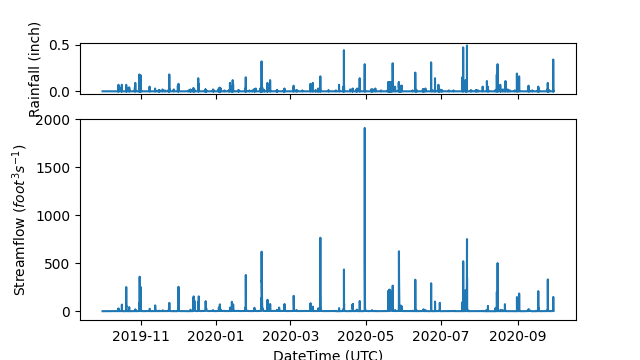

In [10]:
fig, (px, qx) = plt.subplots(ncols=1, nrows=2, figsize=(6.4, 3.6), sharex=True, gridspec_kw={"height_ratios": [1, 4]})
px.plot(rainfall["value_time"], rainfall["value"])
px.set_ylabel("Rainfall (inch)")
qx.plot(streamflow["value_time"], streamflow["value"], "-")
qx.set_xlabel("DateTime (UTC)")
qx.set_ylabel("Streamflow ($foot^3 s^{-1}$)")